# Animal Classifier

- pip install pillow may be required
- write blog post into the notebook
- send over at sunday

## Overview
- Build an image classifer and train it using Cloud GPUs
- Make predictions with the trained model
- Examine model training with Tensorboard
- Try training this model on [Tensorpad](https://tensorpad.com/)
- Use promocode "ClassifierGuide250" for 5 free hours

## Objective
- Load an image dataset in a way that is for efficent training
- Build an image classifier
- Train it using Cloud GPUs
- Examine model training with Tensorboard
    - (Tensorboard)[https://www.tensorflow.org/guide/summaries_and_tensorboard] is "a suite of visualization tools called TensorBoard. You can use TensorBoard to visualize your TensorFlow graph, plot quantitative metrics about the execution of your graph, and show additional data like images that pass through it" 
- Make predictions using the trained model
- Export the trained model

## Getting started
- Create a tensorpad account
- Use promocode "ClassifierGuide250" for 5 free hours
- Clone this project's Github repository
    - `git clone https://github.com/PeterChauYEG/animal_classifier.git`
- Wait for it download
- It contains the dataset so it may take up to 30 minutes.
- When it's done, open `Animal Classifier.pynb` inside the `animal_classifier` directory
- This will open the Jupyter notebook
- Run the whole notebook by using the `Run` menu and selecting `Run All Cells`

## Loading Deps

In [1]:
# Allows access to the file system
import os

# Provides an API for scientific computing
import numpy as np

# Allows use to timestamp the training run
from datetime import datetime

# Allows us to render images and plot data
from keras.preprocessing.image import ImageDataGenerator, img_to_array, load_img
import math
import matplotlib.pyplot as plt

# Machine learning framework that provides an abstract API on top of Tensorflow
import keras
from keras.callbacks import TensorBoard
from keras.layers import Conv2D, Dense, Flatten, MaxPooling2D
from keras.models import Sequential
from keras import optimizers

Using TensorFlow backend.


## Configurations
- Because we are plotting in a Jupyter Notebook, we need to configure `matplotlib` to render plots inline

In [2]:
# configure the matplotlib for jupyter notebooks, used for rendering the images
%matplotlib inline

## Parameters

### Dataset Directories

- Image Dataset should be organized as sets of images in a nested structure. 
- The root directory should hold them all. In the root directory should be several directories.
- Each directory should have the name of the class (eg. cat) of images it holds.
- In each directory should be images of the same class (eg. cat images).

- A seperate dataset directory should be created for each of the following:
    - Training Dataset
        - images which are used during model training
    - Validation Dataset
        - images which are used during model validation
    - Prediction Dataset
        - images which are used when making predictions with the model

- It is important that none of the images in the training dataset are in the validation dataset

In [3]:
# Paths to datasets to be used
train_dir = 'dataset/train'
validate_dir = 'dataset/validate'
predict_dir = 'dataset/predict'

### Hyperparameters
- Used to tune the model and model training
- These greatly influence the resulting metrics
- Tune these to obtain better metrics

- explain hyper parameter choices
- Images will resized to 200x200x3
- this means 200 pixels by 200 pixels with 3 color channels
- using many pixels tends to result in better accuracy
- This can be cause of increased detail
- It also increase computational complexity

- the learning rate is the rate which the model will update the gradients that it is trying to optimize

- batch size is the number of images that will be feed into the model in one iteration

- epoch is the number of times the model should iterate over the entire dataset and update the weights of the model
- at some number of epochs, the gains of training approachs 0

- explain 80/20 split
- This dataset consists of 8000 training image and 2000 validation images
- It is often recommended to split the dataset in a 80:20 ratio. 
- This is a general rule that works reasonably well
- consider this a hyperparameter that can be tuned

In [4]:
# number of images in the training dataset
train_n = 8000

# number of images in the validation dataset
validation_n = 2000

# the number of pixels for the width and height of the image
image_dim = 200

# the size of the image (h,w,c)
input_shape = (image_dim, image_dim, 3)

# the rate which the model learns
learning_rate = 0.001

# size of each mini-batch
batch_size = 32

# nunmber of training episodes
epochs = 1

## Outputs
- we will want to output 2 items:
    - training logs:
        - these can be feed into Tensorboard for analysis
        - useful for understanding how models/hyperparameters compare
    - trained model:
        - for use elsewhere
        
- we want to save the training logs to a directory with a timestamp of when training started, and some data about the hyper parameters used
- we also want to give the model a name when we save it

In [5]:
# directory which we will save training outputs to
# add a timestamp so that tensorboard show each training session as a different run
timestamp = datetime.now().strftime('%Y-%m-%d %H:%M:%S')
output_logs_dir = 'logs/' + timestamp + '-' + str(batch_size) + '-' + str(epochs)

# directory to save the model
model_name = 'trained_model'

## Loading the Dataset
### Image Data Generators
- "Generate batches of tensor image data with real-time data augmentation. The data will be looped over (in batches)." - [Keras](https://keras.io/preprocessing/image/#imagedatagenerator-class)
- allows us to load images from a directory effiecently
- we need to take care in doing this
- a naive approach is to load all the images up front
    - this would result in a huge of amount of used RAM before you start training
- instead we can load images required exactly when we need it, 
    - when feeding a batch of images to the model during training
    - Keras provides an optimized method of doing this
- we also need to transform the data so that it can be used by the model
    - it is easy to do this in an non-optimal manner
    - Keras also provides this functionality optimally
- These generators can also transform the dataset in many other ways to augment the dataset. 
    - explore these optional transforms to help make your model more general, and improve accuracy

In [6]:
# define data generators
train_data_generator = ImageDataGenerator(rescale=1./255,
                                          fill_mode='nearest')
validation_data_generator = ImageDataGenerator(rescale=1./255,
                                               fill_mode='nearest')

# tell the data generators to use data from the train and validation directories
train_generator = train_data_generator.flow_from_directory(train_dir,
                                                          target_size=(image_dim, image_dim),
                                                          batch_size=batch_size,
                                                          class_mode='categorical')

validation_generator = validation_data_generator.flow_from_directory(validate_dir,
                                                          target_size=(image_dim, image_dim),
                                                          batch_size=batch_size,
                                                          class_mode='categorical')

Found 8000 images belonging to 10 classes.
Found 2000 images belonging to 10 classes.


### Get Class Names

- It is useful to have a dictionary of image classes
- we can use this dictionary to make our predictions more human-readable

In [7]:
# get a dictionary of class names
classes_dictionary = train_generator.class_indices

# turn classes dictionary into a list
class_keys = list(classes_dictionary.keys())

# get the number of classes
n_classes = len(class_keys)

## Create a model
- conv2D is a 2 dimensional convolutional layer
- it applies filters over an image 
- this helps the model learn about spatial relationships

- ReLu is a type of non-linear activation function
- these help the model understand which neurons are activating on a given image

- max pooling down samples an input.
- we use it to reduce the dimensionality of input
- this helps create a more abstract from of the input

- flatten will turn a matrix into a row. Like flattening a muffin into a pancake
- we use it so that we can feed the output into dense layers

- dense is a densely-connected neural network layer

- the last layer has the same number of neurons as classes 
- this means that this layer will output 10 numbers

- softmax is an activation function
- it is used here to turn the output numbers into a range of 0 and 1.
- it will also cause all the numbers to add up to 1
- this can be interpeted as the decimal probability of a class

In [8]:
# define the model 
# takes in images, convoles them, flattens them, classifies them
model = Sequential([
    Conv2D(16, (3, 3), activation='relu', padding='same', input_shape=input_shape),
    Conv2D(16, (3, 3), activation='relu', padding='same'),
    MaxPooling2D(pool_size=(2,2), strides=None, padding='valid'),
    Conv2D(32, (3, 3), activation='relu', padding='same'),
    Conv2D(32, (3, 3), activation='relu', padding='same'),
    MaxPooling2D(pool_size=(2,2), strides=None, padding='valid'),
    Conv2D(64, (3, 3), activation='relu', padding='same'),
    Conv2D(64, (3, 3), activation='relu', padding='same'),
    MaxPooling2D(pool_size=(2,2), strides=None, padding='valid'),
    Conv2D(128, (3, 3), activation='relu', padding='same'),
    Conv2D(128, (3, 3), activation='relu', padding='same'),
    MaxPooling2D(pool_size=(2,2), strides=None, padding='valid'),
    Flatten(),
    Dense(256, activation='relu'),
    Dense(n_classes, activation='softmax')
])

In [9]:
# define the optimizer and loss to use
model.compile(optimizer=optimizers.SGD(lr=learning_rate, momentum=0.9),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

### Examine the Model
- we can generate a high-level overview of the model structure
- each row is a layer of the model

In [10]:
# look at the defined model
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 200, 200, 16)      448       
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 200, 200, 16)      2320      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 100, 100, 16)      0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 100, 100, 32)      4640      
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 100, 100, 32)      9248      
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 50, 50, 32)        0         
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 50, 50, 64)        18496     
__________

## Train and Validate the model

In [11]:
# log information for use with tensorboard
tensorboard = TensorBoard(log_dir=output_logs_dir)

In [12]:
# train the model using the training data generator
model.fit_generator(train_generator,
                    steps_per_epoch=math.floor(train_n/batch_size),
                    validation_data=validation_generator,
                    validation_steps=validation_n,
                    epochs=epochs,
                    callbacks=[tensorboard])

Epoch 1/1
250/250 [==============================] - 145s 578ms/step - loss: 2.3017 - acc: 0.1126 - val_loss: 2.2993 - val_acc: 0.1455


## validate model

- show differences of class predictions as training progresses
    - none
    - some trianing
    - alot of training
    - fully trained

## Understanding training metrics
- We try to maximize validation accuracy while minimizing validation loss
- training and validation accuracies should be similar at the end of training
- if these values aren't, this could be a sign of overfitting
- you should see training loss (loss) decrease, training accuracy (acc) increase for the training data
- you should see validation loss (val_loss) decrease, validation accuracy (val_acc) increase for the validation data

## Tensorboard

- on `Tensorpad`, you can use the commands tab to create a new tensorboard.
- point it to `animal_classifier/logs`
- here you'll be able to visualize the accuracy of your model over epochs
- each training run creates a new set of logs. This appears in Tensorboard as a seperate plotted line
- The following are screenshots of my training results plotted on Tensorboard
- Your results should look similar

### Training Loss

![Training Loss](assets/loss.png "Training Loss")

### Training Accuracy
![Training Accuracy](assets/acc.png "Training Accuracy")

### Validation Loss
![Validation Loss](assets/val_loss.png "Validation Loss")

### Validation Accuracy
![Validation Accuracy](assets/val_acc.png "Validation Accuracy")

## Functions

In [13]:
def get_class_labels(dir):
    """
    Gets the name of each directory in the directory.
    
    dir: Directory which holds directories.
    return: An array of the names of the directories in dir.
    """
    
    # Get all directories in this directory
    classes = os.listdir(dir)
    
    return classes

In [14]:
def get_class_images(classes, dir):
    """
    Gets the paths of all images in each directory.
    
    classes: Name of each class.
    dir: Directory which holds directories.
    return: A 2d array of paths organized by class name.
    """
    
    # Create an array to hold the image paths of each class
    class_paths = []

    # Create image paths of each class
    for label in classes:
        
        # Create an array to hold the image paths of this class (label)
        image_paths = np.array([])

        # Create the path of this class
        class_path = os.path.join(dir, label)

        # Get all images in this directory
        images = os.listdir(class_path)

        # Create the path of each images in this class
        for image in images:
            
            # Create the path of this image
            image_path = os.path.join(class_path, image)

            # Add the image path to the image paths array
            image_paths = np.append(image_paths, image_path)

        # Add the image paths to the class paths array
        class_paths.append(image_paths)
        
    return class_paths

In [15]:
def setup_fig(h, w):
    """
    Sets up a matplotlib figure which can be used to plot images
    
    return: A configured matplotlib figure
    """
    fig = plt.figure(figsize=(h, w), tight_layout=True)
    fig.set_facecolor('white')
    return fig

In [16]:
def plot_image(cols, fig, image_path, subplot_index, subplot_label):
    """
    Loads an image from a path, then renders it to the figure with a label
    
    cols: total number of images to be plotted, if calling this many times for a figure
    fig: figure to plot the image onto
    image_path: path to the image to be plotted
    subplot_index: Index describing where in the figure the image should be plotted
    subplot_label: Label for the subplot
    """
    
    # load the image
    image_pil = load_img(image_path, interpolation='nearest', target_size=(200,200))
        
    # render an image to the plot
    ax = fig.add_subplot(1, cols, subplot_index)
    ax.imshow(image_pil)
    ax.set_xticks([])
    ax.set_yticks([])
    ax.set_title(subplot_label)

In [17]:
def prediction(class_keys, image_path, model):
    """
    Makes a prediction with the model and plots the image used in the prediction
    
    class_keys: list of class keys
    image_path: path to an image
    model: image classifier model
    
    """
    # load the image
    image_pil = load_img(image_path, interpolation='nearest', target_size=(image_dim, image_dim, 3))
    
    # turn it into an array
    image_arr = img_to_array(image_pil)
    
    # turn it into a numpy array so that it can be feed into the model as a batch
    image = np.array([image_arr])
    
    # make a prediction on the batch
    prediction = model.predict(image, batch_size=1)
    
    # determine the most likely class from the prediction
    most_likely_class = np.argmax(prediction[0])
    
    # add class labels for the prediction
    # remember that we feed in a batch so we need to grab the first prediction
    prediction_classes = [str(class_keys[index]) + ": " + str(round(prob*100, 4)) + "%" for index, prob in enumerate(prediction[0])]
    
    # generate the prediction label
    subplot_label = "Prediction: " + str(class_keys[most_likely_class]) + "\nProbabilities: " + ', '.join(prediction_classes)
    
    # setup a plot and plot the image
    fig = setup_fig(7, 7)
    plot_image(1, fig, image_path, 1, subplot_label)

## Predict
- We have metrics for how well the model performed
- lets also see some predictions
- it is useful to know which image predictions were correct and wrong
- Make 10 predictions
- 1 prediction per class
- Display predicted class, probabilities of each class, and image

In [18]:
# Get the name of each directory in the root directory and store them as an array.
# These are the classes.
classes = get_class_labels(predict_dir)

# Get the paths of all the images in each class directory and store them as a 2d array.
# These are the class images paths.
image_paths = get_class_images(classes, predict_dir)

/opt/conda/lib/python3.6/site-packages/matplotlib/figure.py:2267: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  warnings.warn("This figure includes Axes that are not compatible "


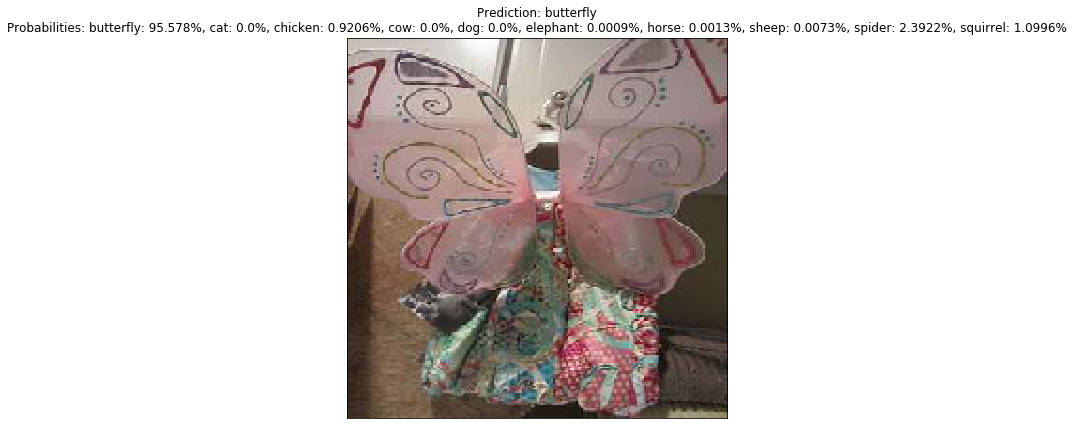

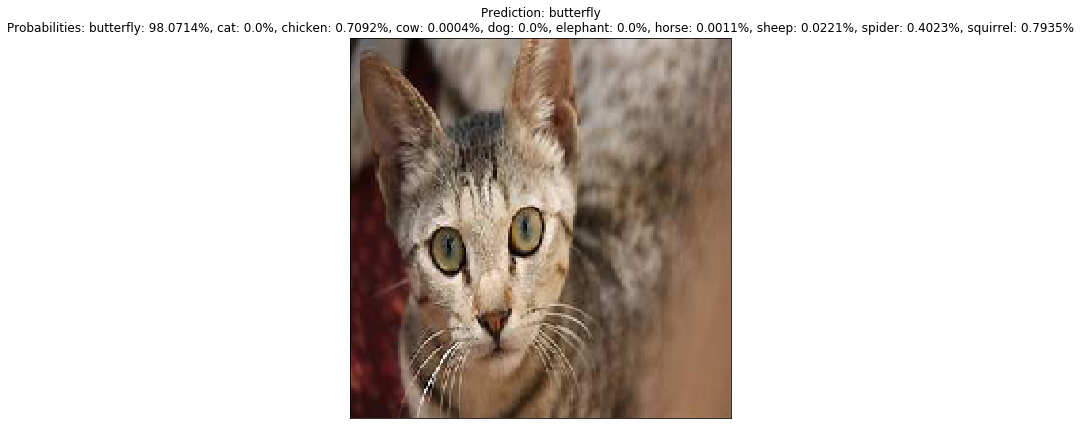

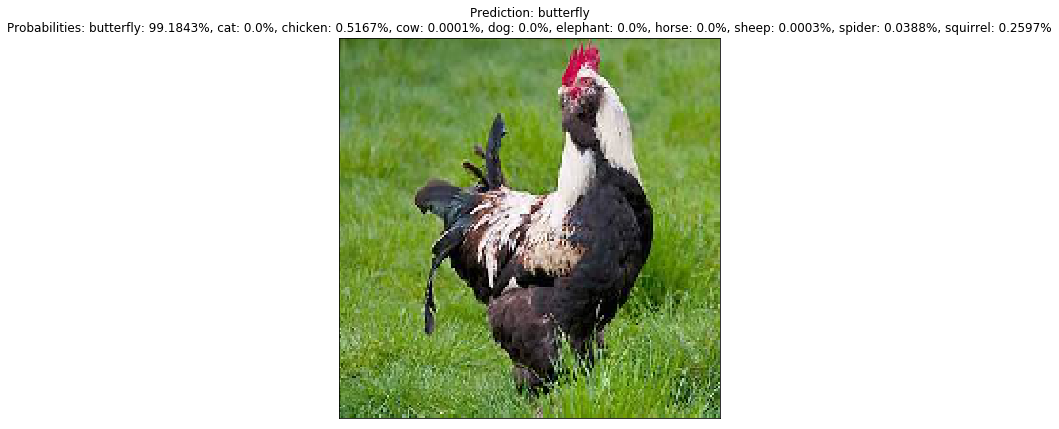

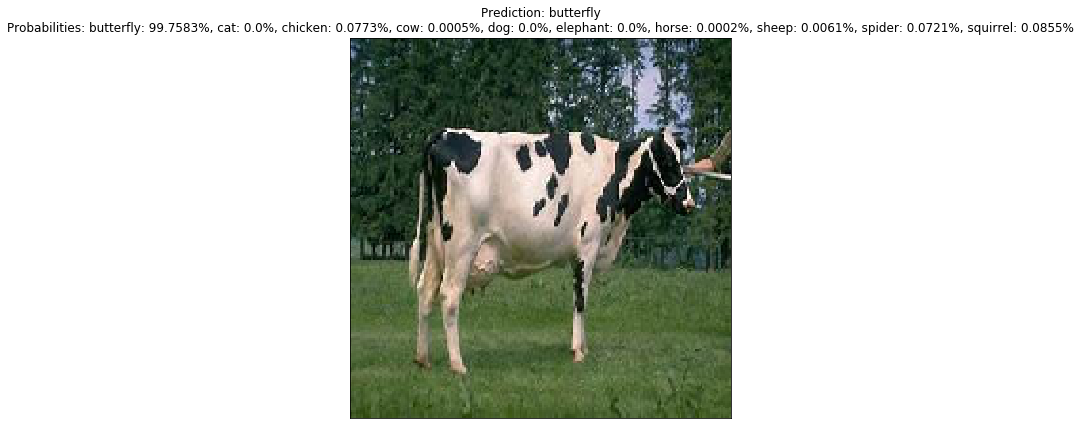

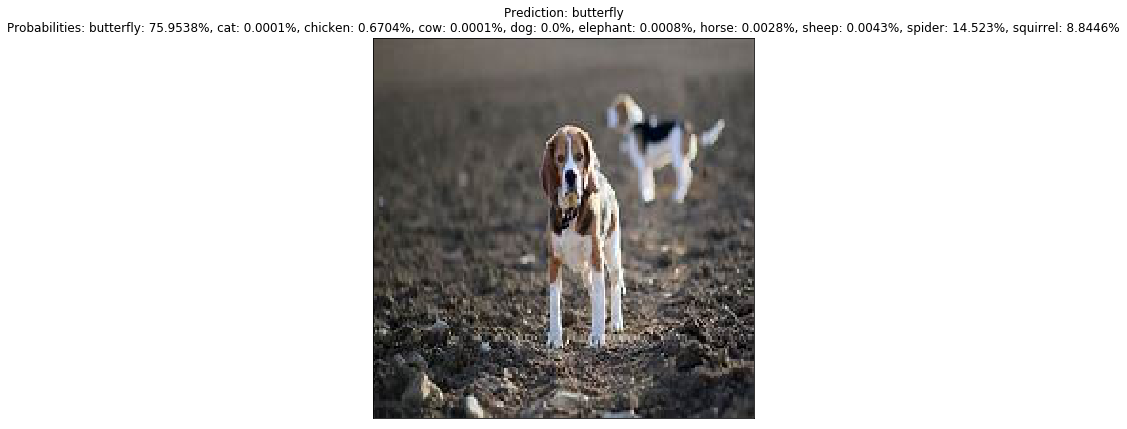

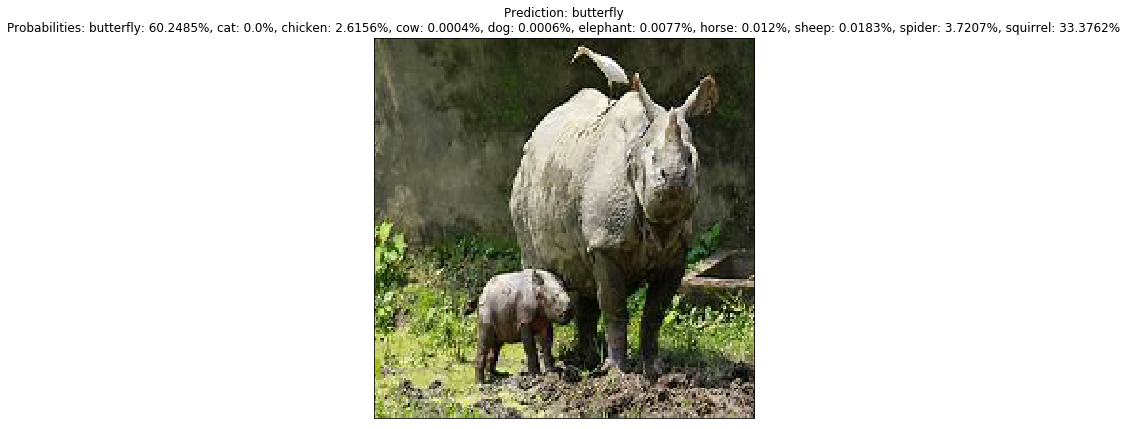

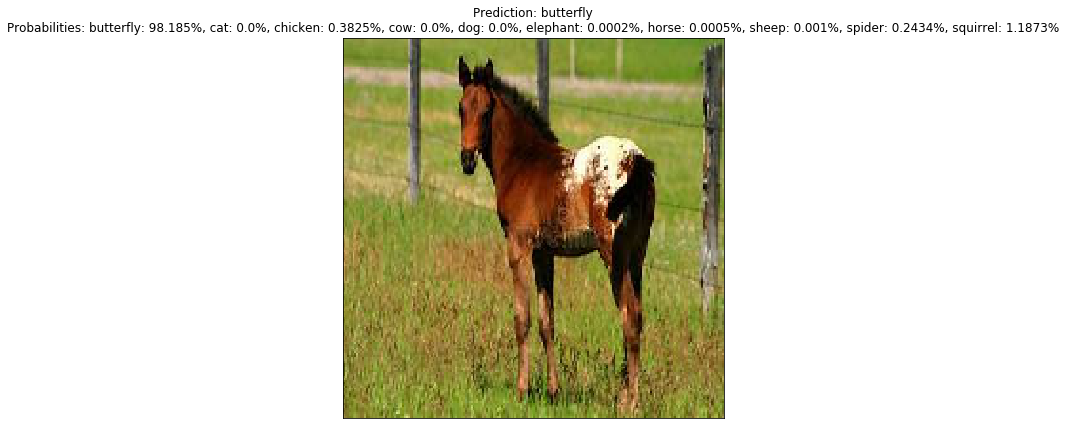

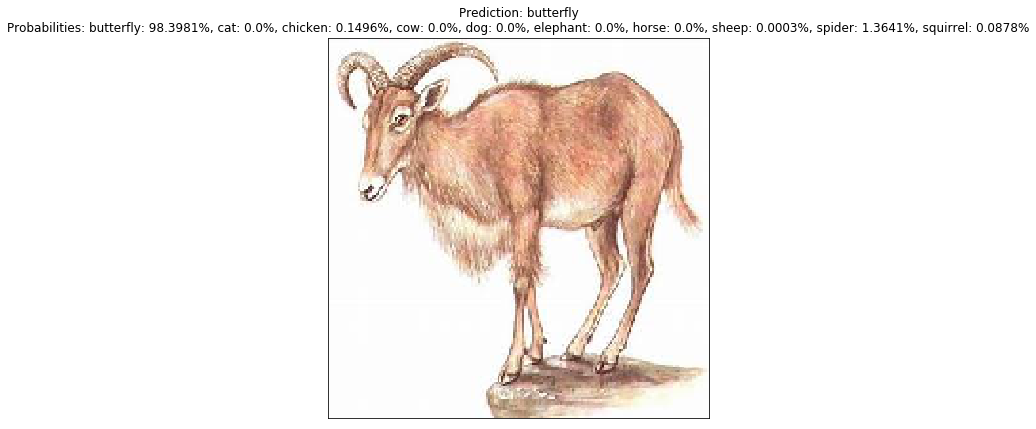

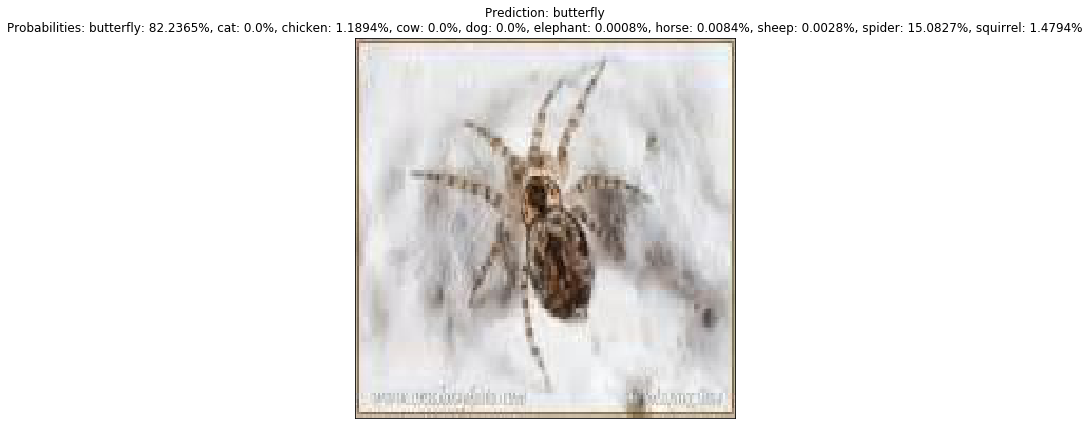

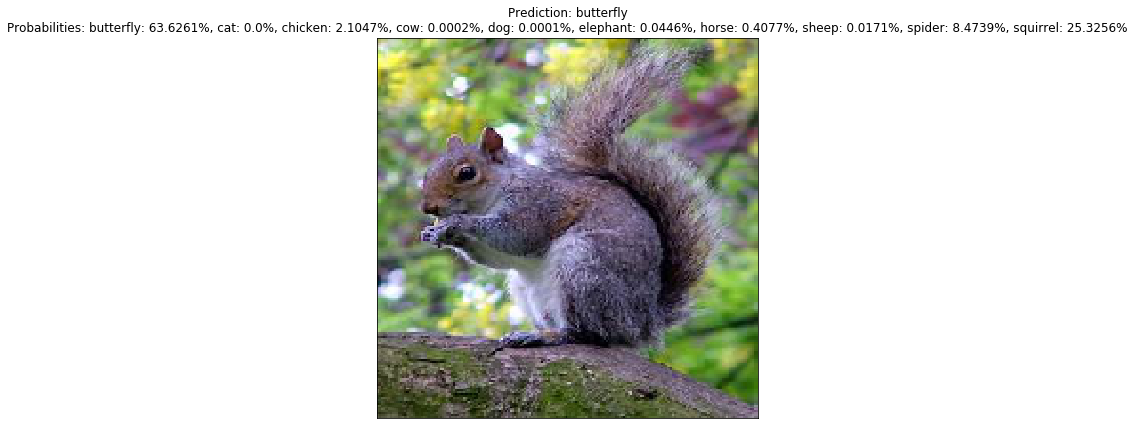

In [19]:
for image_path in image_paths:
    prediction(class_keys, image_path[0], model)

## Exporting the Trained Model
- What do you do with a trained model?
- Export for your applications!
- This also allows you to use the training model instead of training every time
- There are many formats you can export in
- Here, we will export it so that it can be loaded up by this notebook

In [20]:
# export the model for later
model.save(model_name)

## Next Steps
- Examine hyperparameter sweeping and improving accuracy
- Improving model architecture

## Learning Resources
- provide learning resources
- [Andrew Ng's course on Machine Learning](https://www.coursera.org/learn/machine-learning) is considered a standard. It is often recommended.
- [Fast.ai](https://www.fast.ai/) provide many excellent courses to learn Machine Learning
- [Keras - Guide to the Sequential Model](https://keras.io/getting-started/sequential-model-guide/) is a great starter to building models with Keras.

## References
[Keras](https://keras.io/)  
[Animals 10 dataset](https://www.kaggle.com/alessiocorrado99/animals10)